# Segmentation

## Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

sns.set()

In [2]:
def plot_histogram(df: pd.DataFrame, feature_name: str, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    sns.countplot(df[feature_name], ax=ax)
    N = len(df[feature_name])
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/N), (x.mean(), y), ha='center', va='bottom')

def plot_correlation_map(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.heatmap(
        df.corr(), annot=True, fmt='0.2f', vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200), square=True, ax=ax
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

## Data

The dataset is provided by 365 Data Science Customer Analytics course. It consists of information about the purchasing behavior of 2,000 individuals from a given area when entering a physical FMCG store. We can view the data as a sample that is representative of the whole country. All data has been collected through the loyalty cards they use at checkout. The data has been preprocessed and there are no missing values. In addition, the volume of the dataset has been restricted and anonymised to protect the privacy of the customers. 

In [3]:
df_data = pd.read_csv('data/fmcg-store-customers.csv')

In [4]:
df_data.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


The data consists of demographic and geographical variables:

| Variable        | Data type   | Range     | Description                                                                                                                                                   |   |
|-----------------|-------------|-----------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|---|
| ID              | numerical   | Integer   | Shows a unique identificator of a customer.                                                                                                                   |   |
| Sex             | categorical | {0,1}     | Biological sex (gender)   of a customer. In this dataset there are only 2 different options. 0 = Male,   1=Female                                             |   |
| Marital status  | categorical | {0,1}     | Marital status of a   customer. 0=Single, 1=non-single (divorced / separated / married / widowed)                                                             |   |
| Age             | numerical   | Integer   | The age of the customer   in years, calculated as current year minus the year of birth of the customer   at the time of creation of the dataset               |   |
| Education       | categorical | {0,1,2,3} | Level of education of the   customer. 0=other/unknown, 1=high school, 2=university, 3=graduate   school                                                       |   |
| Income          | numerical   | Real      | Self-reported annual income in US dollars of the customer.                                                                                                    |   |
| Occupation      | categorical | {0,1,2}   | Category of occupation of   the customer. 0=unemployed/unskilled, 1=skilled employee/official,   2=management/self-employed/highly qualified employee/officer |   |
| Settlement size | categorical | {0,1,2}   | The size of the city that the customer lives in. 0=small,   1=mid-sized, 2=big                                                                                |   |

In [5]:
id_features = ['ID']
numerical_features = ['Age', 'Income']
categorical_features = ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']

## Feature Exploration

We know that the data is is preprocessed and there are no missing values.

### Gender

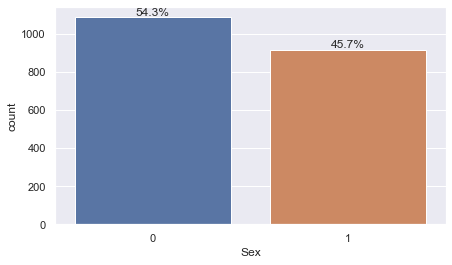

In [6]:
plot_histogram(df_data, 'Sex')

### Marital Status

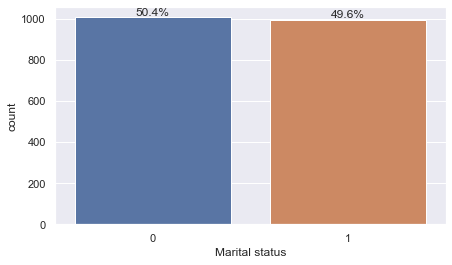

In [7]:
plot_histogram(df_data, 'Marital status')

### Education

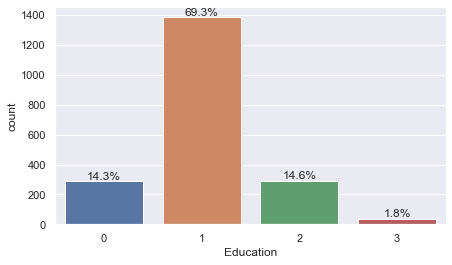

In [8]:
# 0=other/unknown, 1=high school, 2=university, 3=graduate school
plot_histogram(df_data, 'Education')

### Occupation

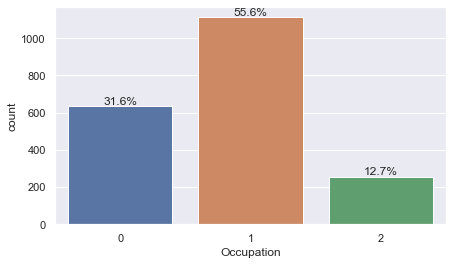

In [9]:
# 0=unemployed/unskilled, 
# 1=skilled employee/official, 
# 2=management/self-employed/highly qualified employee/officer
plot_histogram(df_data, 'Occupation')

### Settlement Size

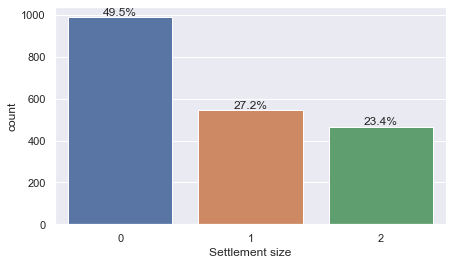

In [10]:
#  0=small city, 1=mid-sized city, 2=big city
plot_histogram(df_data, 'Settlement size')

### Age

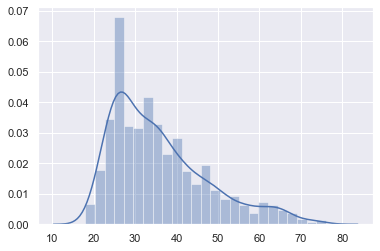

In [11]:
sns.distplot(df_data[['Age']]);

### Income

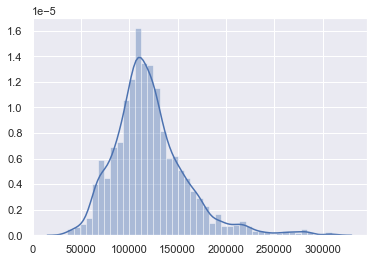

In [12]:
sns.distplot(df_data[['Income']]);

## Pairs of Features

### Correlation

Correlation help us understand the linear relationships between the pairs of features.

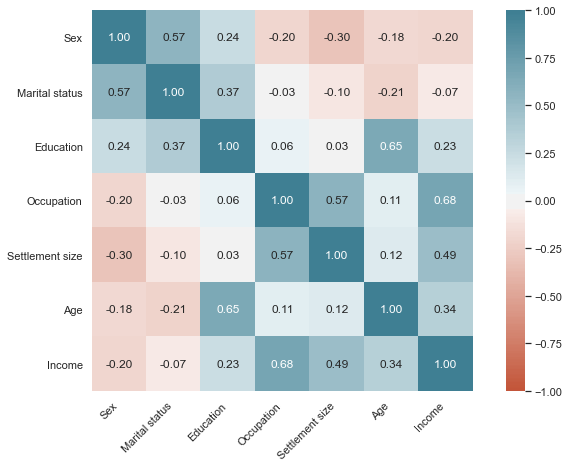

In [13]:
plot_correlation_map(df_data[categorical_features + numerical_features])

- Positive correlation between Income and Occupation. We can expect managers to earn more than unskilled employees.
- Positive correlation between Education and Age. This makes some sense. We do not expect 18 years to have a university degree.
- Interesting correlation between Marital status and Gender.

### Age and Income

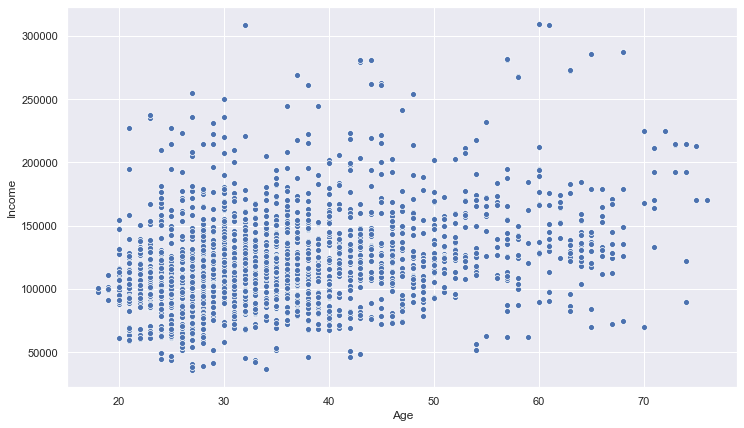

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(x='Age', y='Income', data=df_data, ax=ax);

## Clustering

The goal of clustering is two-fold:
1. Group individual samples based on their similarity. To determine the similarity between samples, we can use the Euclidean/Manhattan distance between samples.
2. Ensure that distance between groups are as large as possible. To determine the distance between groups, we can use the Ward's minimum variance method.

### Hierarchical Clustering

Two types of hierarchical clustering:
- Divisive (top down): Initially, all samples belong to one cluster. The big cluster is split into two smaller clusters. We keep splitting the clusters until each sample is a separate cluster. To find the best split, we must consider explore all possible splits at each step.
- Agglomerative (bottom up): Initially, each sample belong to their own cluster. At each step, we combine clusters together until we reach one big cluster. Usually, preferred over divisive because it is easier to solve mathematically.

Since the number of samples is limited, we will use hierarchical clustering because it can automatically find the number of clusters in the data. This is useful when we have no prior knowledge of number of clusters. However, it is inefficient and the computation time would be much longer if the data size was larger. In such cases, we can use flat clustering methods such as k-means. In some cases, it makes sense to perform hierarchical clustering to determine clusters and then apply flat clustering for segmentation.

In [15]:
# Perform standardisation of the data so each feature have the same scale
scaler = StandardScaler()
df_data_std = scaler.fit_transform(df_data[categorical_features + numerical_features])

In [16]:
df_data_std.shape

(2000, 7)

In [17]:
linkage_matrix = linkage(df_data_std, method='ward')

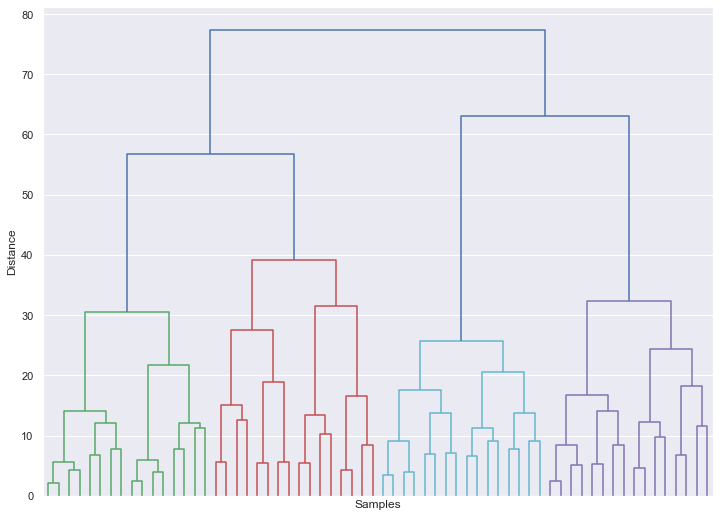

In [18]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlabel('Samples')
ax.set_ylabel('Distance')

# A dendogram is a tree-like hierarchical structure for representating the clusters
dendrogram(linkage_matrix, truncate_mode='level', p=5, show_leaf_counts=False, no_labels=True, ax=ax);

The `linkage` function found four clusters automatically. 

> If we had to find the clusters ourselves, we would have to find a horisontal line in the dendogram in which to cut. 
One heuristic is to find the longest vertical line which is not intercepted by a horizontal line in the dendrogram.

### k-Means

There is a few issues with k-Means:
- $k$ or the number of cluster is a hyperparameter that we must specify beforehand. If $k$ is too small, the centroids may not lie inside the clusters. If it is too large, some of the clusters may be split into two.
- The squared Euclidian distance is sensitive to outliers. Usually, points that are two far away from the rest of samples will become a cluster of their own. To avoid this, we can use k-Medians clustering. However, k-Medians is more computationally expensive.
- Enforces clusters which have spherical shape. This is because we minimise the Euclidean distance. k-Means have difficulty separating elongated clusters.

Usually, k-means yields good segmentation results because the groups of samples have spherical shape.